In [10]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm

In [2]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import re
from bs4 import BeautifulSoup

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
#alternate sentiment model 
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

sentiment_model = AutoModelForSequenceClassification.from_pretrained(MODEL)
sentiment_model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
device = torch.device("cuda")
sentiment_model.to(device)
sentiment_model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [67]:
def predict_sentiment(text):  
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt').to(device)
  output = sentiment_model(**encoded_input)
  scores = output[0][0].detach().cpu().numpy()
  scores = softmax(scores)
  score = 0
  for i in range(len(scores)):
    score += (i-1)*scores[i]
  return score

In [68]:
generations = pd.read_csv('../../Data/Study3/modified_generation_data.csv')

In [69]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

In [70]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
  r1 = np.array(r1)
  r2 = np.array(r2)
  return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [71]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(predict_sentiment(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [01:20<00:00,  1.27it/s]


In [72]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [73]:
x = []
y = []
for id in exploration:
  # if .7 < individual_sentiment[id] < .9:
    x.append(individual_sentiment[id])
    y.append(exploration[id])

In [74]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [75]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

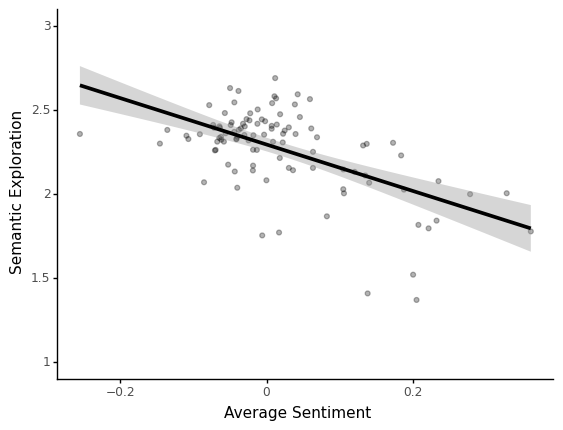

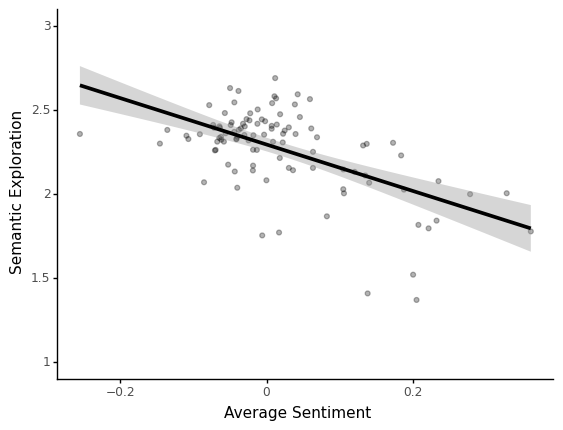

In [76]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(1,3)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [77]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [78]:
generations

Unnamed: 0  Unnamed: 0.1 vignette_name  generation_number  \
0              0             0     scenario4                  1   
1              1             1     scenario4                  2   
2              2             2     scenario4                  3   
3              3             3     scenario4                  4   
4              4             4     scenario4                  5   
...          ...           ...           ...                ...   
3315        3315          3315     scenario8                  4   
3316        3316          3316     scenario8                  5   
3317        3317          3317     scenario8                  6   
3318        3318          3318     scenario8                  7   
3319        3319          3319     scenario8                  8   

      generation_time                                           response  \
0               3.668                                              sleep   
1               2.471                                                eat   
2               2.672                                               read   
3               5.778                                       watch a show   
4               4.766                                    talk to someone   
...               ...                                                ...   
3315           31.786                                       Tell a joke.   
3316           15.107                            Push the emergency stop   
3317           25.589  Take a video for social media showing your "ne...   
3318           34.393  Complain that you have to go to work/appointme...   
3319          128.983  Pass gas, blame in on the person immediately n...   

      reflection_score  id  
0             1.000000  34  
1             1.000000  34  
2             1.000000  34  
3             1.000000  34  
4             1.000000  34  
...                ...  ..  
3315          0.428571  47  
3316          0.142857  47  
3317          0.285714  47  
3318          0.428571  47  
3319          0.142857  47  

[3320 rows x 8 columns]

In [24]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in tqdm(generations.groupby("id")):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    e = 0
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        # exploration[pnum] = dist_fn(embeddings[i], embeddings[j]) + exploration.get(pnum)
        e += dist(embeddings[i], embeddings[j])
    exploration[pnum].append(e/len(embeddings))
    exp.append(e/len(embeddings))
    nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:58<00:00,  1.74it/s]


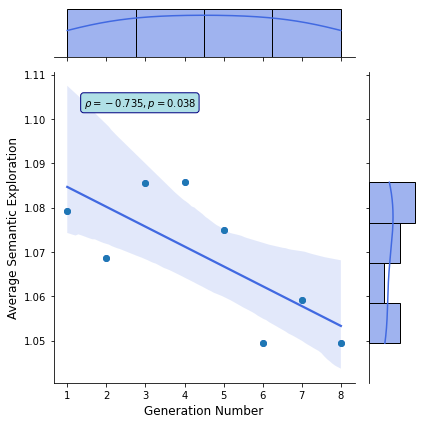

In [25]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [26]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

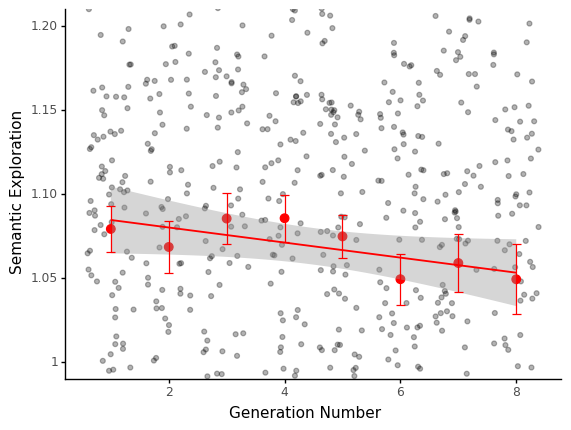

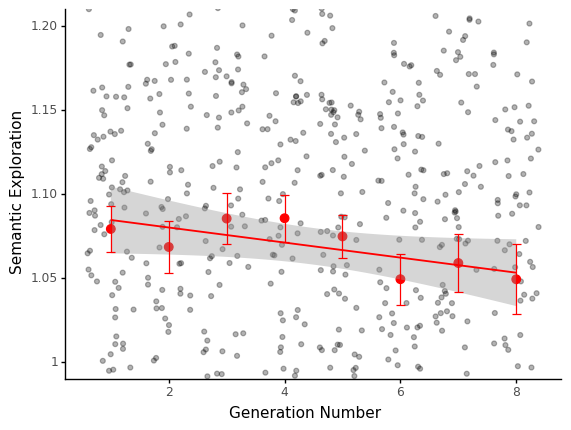

In [28]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(1,1.20)) +
 plotnine.theme_classic()
  ).draw()

In [29]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

# **Semantic Dissimilarity vs Generation Number**

In [30]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in tqdm(generations.groupby("id")):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    vectordic.get(pnum).append(embeddings)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [01:15<00:00,  1.35it/s]


In [31]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [32]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

In [33]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [34]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [35]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

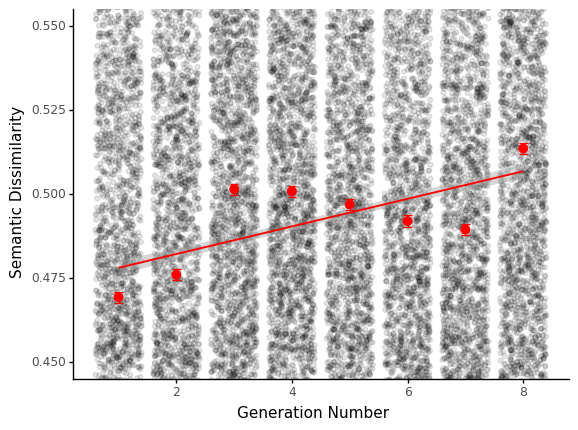

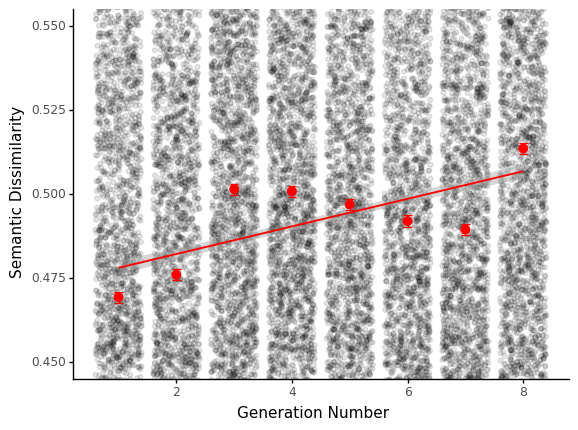

In [37]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.45,.55)) +
 plotnine.theme_classic()
  ).draw()

In [38]:
generations

Unnamed: 0  Unnamed: 0.1 vignette_name  generation_number  \
0              0             0     scenario4                  1   
1              1             1     scenario4                  2   
2              2             2     scenario4                  3   
3              3             3     scenario4                  4   
4              4             4     scenario4                  5   
...          ...           ...           ...                ...   
3315        3315          3315     scenario8                  4   
3316        3316          3316     scenario8                  5   
3317        3317          3317     scenario8                  6   
3318        3318          3318     scenario8                  7   
3319        3319          3319     scenario8                  8   

      generation_time                                           response  \
0               3.668                                              sleep   
1               2.471                                                eat   
2               2.672                                               read   
3               5.778                                       watch a show   
4               4.766                                    talk to someone   
...               ...                                                ...   
3315           31.786                                       Tell a joke.   
3316           15.107                            Push the emergency stop   
3317           25.589  Take a video for social media showing your "ne...   
3318           34.393  Complain that you have to go to work/appointme...   
3319          128.983  Pass gas, blame in on the person immediately n...   

      reflection_score  id  
0             1.000000  34  
1             1.000000  34  
2             1.000000  34  
3             1.000000  34  
4             1.000000  34  
...                ...  ..  
3315          0.428571  47  
3316          0.142857  47  
3317          0.285714  47  
3318          0.428571  47  
3319          0.142857  47  

[3320 rows x 8 columns]

# **Subjective Goodness vs Generation Number**

In [44]:
#average goodness rating per possibility 
scores = [[] for i in range(8)]
nums = [i for i in range(8)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  print(len(group1))
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum-1)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

418
418
416
418
417
411
411
411


In [45]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [46]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


In [47]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(.8,1)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [80]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in tqdm(generations.groupby('id')):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = predict_sentiment(generation)
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:27<00:00,  3.68it/s]


In [81]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

In [82]:
y

[0.0759139358997345,
 0.10000071302056313,
 0.008756846189498901,
 0.05045071244239807,
 -0.057269759476184845,
 -0.05570031702518463,
 -0.581138651818037,
 -0.04986034333705902,
 0.09728274121880531,
 -0.0031413882970809937,
 -0.14415714144706726,
 -0.0435003787279129,
 -0.07717768102884293,
 0.1364700011909008,
 -0.12259282544255257,
 -0.1406518816947937,
 -0.32827433198690414,
 -0.5760791599750519,
 -0.15441735088825226,
 -0.09829016029834747,
 -0.12627631425857544,
 0.2270449548959732,
 -0.10327120870351791,
 -0.09968039393424988,
 -0.12259282544255257,
 -0.15901381894946098,
 0.060145869851112366,
 0.17023469507694244,
 -0.13404302299022675,
 -0.0386638268828392,
 -0.0643012747168541,
 0.062468186020851135,
 0.9308618088252842,
 0.16448315232992172,
 0.673824958736077,
 0.4298604726791382,
 0.09333829954266548,
 0.0376046746969223,
 -0.16080451756715775,
 -0.07823941111564636,
 0.015737585723400116,
 0.09923148155212402,
 -0.17192025668919086,
 -0.1446036547422409,
 0.150139900855

In [83]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [84]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


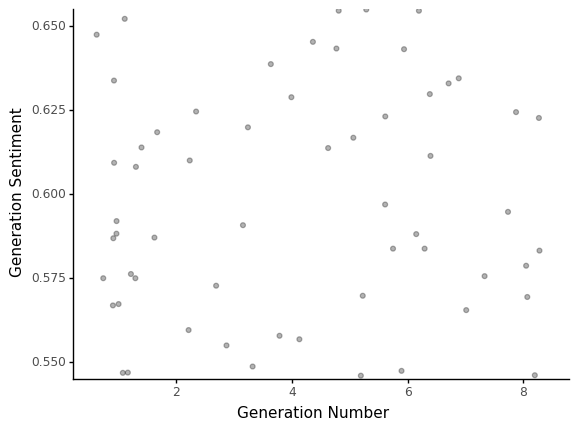

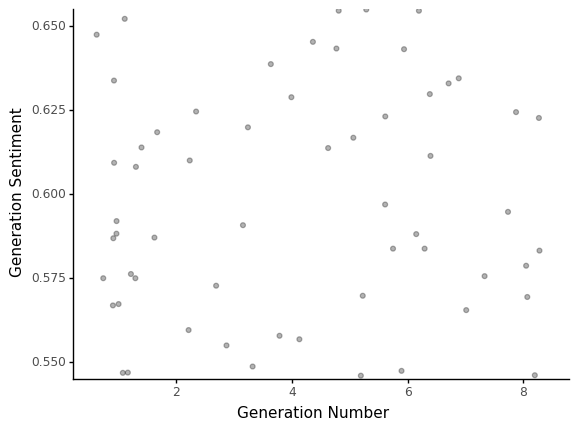

In [85]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [86]:
concreteness = pd.read_csv("../../Data/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [87]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [88]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in tqdm(generations.groupby("id")):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 55.77it/s]


In [89]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.9543243956456986, 2: 2.966650881921344, 3: 2.9952121826146283, 4: 2.976247362073151, 5: 3.015950769512224, 6: 2.8973082095927984, 7: 2.920181640805666, 8: 2.96672255027465}


In [90]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [91]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

In [93]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.8,3.1))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [94]:
#bin the generations based on concreteness 
gens = {}
for response, group in tqdm(generations.groupby("response")):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2720/2720 [00:00<00:00, 39939.74it/s]


In [95]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

2577

In [96]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [98]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
similarity 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


{0: [0.809695228934288,
  0.7049340307712555,
  0.8784936144948006,
  0.8742465227842331,
  0.7857653498649597,
  0.870817556977272,
  0.9399644732475281,
  0.9146166369318962,
  0.6498113572597504,
  0.7911779433488846,
  0.9169113114476204,
  0.662115216255188,
  0.7415274679660797,
  0.7669151574373245,
  0.8642368465662003,
  0.9500367268919945,
  0.7763156443834305,
  0.745541125535965,
  0.9244989976286888,
  0.6483077704906464,
  0.6701492369174957,
  0.7874983996152878,
  0.817951038479805,
  1.0377308689057827,
  0.9137158021330833,
  0.8522791415452957,
  0.862633466720581,
  0.8095580041408539,
  0.667148232460022,
  0.9873355943709612,
  0.8336502611637115,
  0.8278364092111588,
  0.7592817544937134,
  0.6602629721164703,
  0.6990325450897217,
  0.7851283997297287,
  0.8887670859694481,
  0.7438481152057648,
  0.7453369200229645,
  0.7937590330839157,
  0.9718629866838455,
  0.868074357509613,
  0.5856747031211853,
  0.9140464067459106,
  0.8067594766616821,
  0.20486170053

In [99]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [100]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

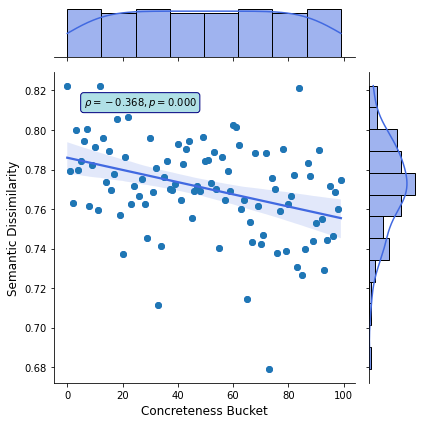

In [101]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

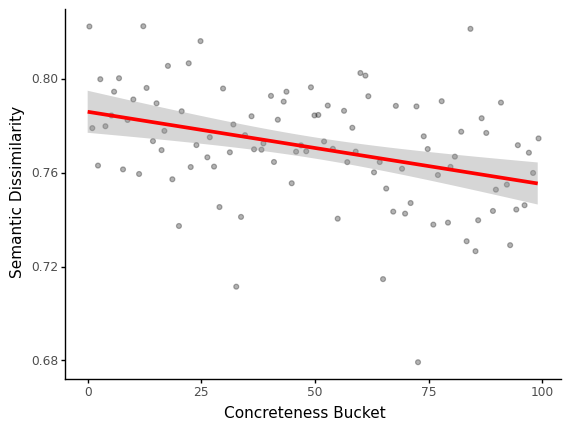

In [102]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [103]:
# semantic exploration 
exploration = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:52<00:00,  1.94it/s]


In [104]:
#determine avg concreteness 
id_concreteness = {}
for id, group in tqdm(generations.groupby("id")):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 1050.40it/s]


In [105]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [106]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

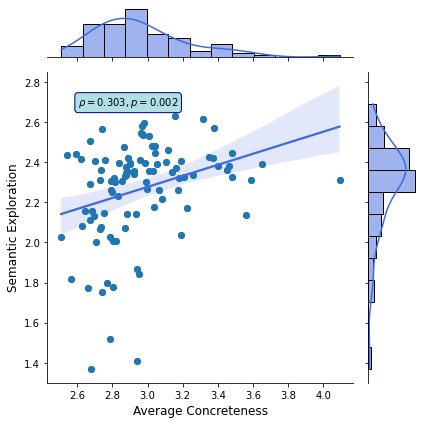

In [107]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

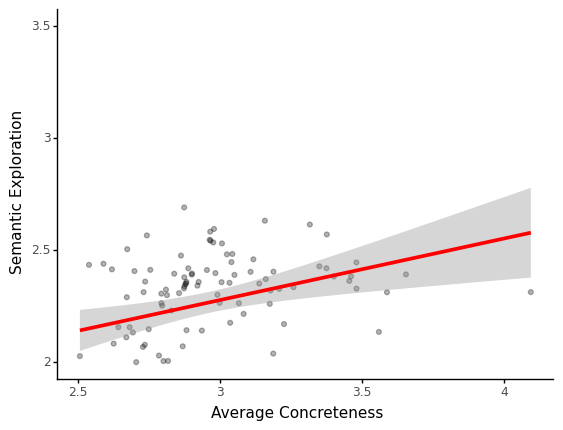

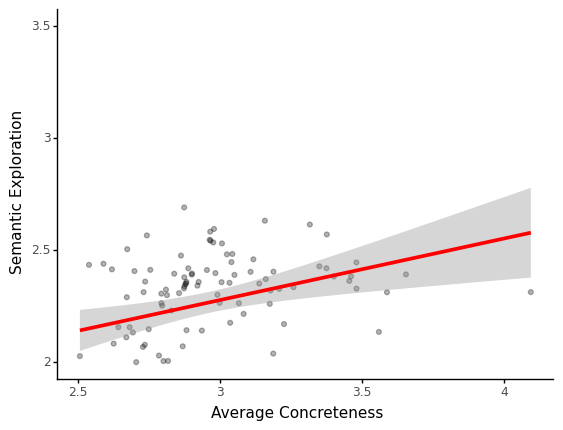

In [108]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [109]:
concreteness = []
subjective = []
for response, group in tqdm(generations.groupby("response")):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2720/2720 [00:00<00:00, 11177.57it/s]


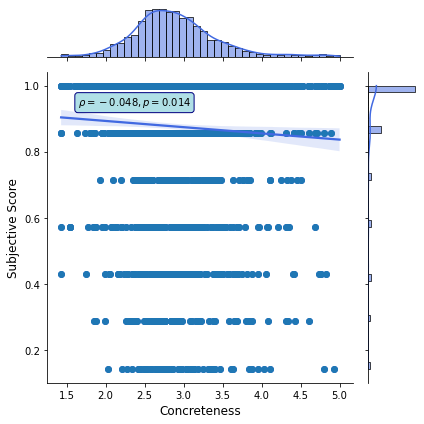

In [110]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [114]:
concreteness = []
sentiment = []
for response, group in tqdm(generations.groupby("response")):
  words = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(words.split(" "))
  for word in words.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(predict_sentiment(response))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2720/2720 [00:20<00:00, 131.68it/s]


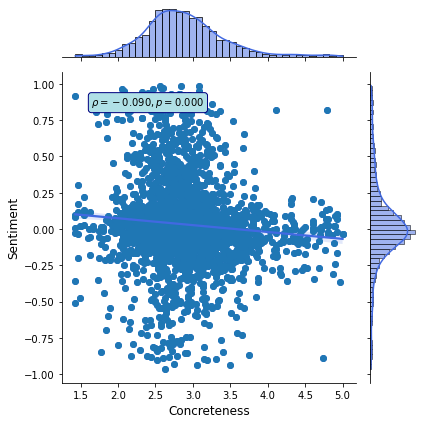

In [115]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()

# **Timed Analysis**
Results to develop here: 


1.   Total sematic exploration (adjusted) vs time
2.   Successive Semantic Distance vs time
3.  Time vs Distance from center of mass 
4.  Total time vs Generation Number
5. Generation Time v Concreteness 



# **Total Semantic Exploration (adjusted) vs Time**

In [116]:
generations

Unnamed: 0  Unnamed: 0.1 vignette_name  generation_number  \
0              0             0     scenario4                  1   
1              1             1     scenario4                  2   
2              2             2     scenario4                  3   
3              3             3     scenario4                  4   
4              4             4     scenario4                  5   
...          ...           ...           ...                ...   
3315        3315          3315     scenario8                  4   
3316        3316          3316     scenario8                  5   
3317        3317          3317     scenario8                  6   
3318        3318          3318     scenario8                  7   
3319        3319          3319     scenario8                  8   

      generation_time                                           response  \
0               3.668                                              sleep   
1               2.471                                                eat   
2               2.672                                               read   
3               5.778                                       watch a show   
4               4.766                                    talk to someone   
...               ...                                                ...   
3315           31.786                                       Tell a joke.   
3316           15.107                            Push the emergency stop   
3317           25.589  Take a video for social media showing your "ne...   
3318           34.393  Complain that you have to go to work/appointme...   
3319          128.983  Pass gas, blame in on the person immediately n...   

      reflection_score  id  
0             1.000000  34  
1             1.000000  34  
2             1.000000  34  
3             1.000000  34  
4             1.000000  34  
...                ...  ..  
3315          0.428571  47  
3316          0.142857  47  
3317          0.285714  47  
3318          0.428571  47  
3319          0.142857  47  

[3320 rows x 8 columns]

In [117]:
# total (adjusted) exploration vs total generation time 
exploration = {}
times = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  times[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        times[id] += list(group3["generation_time"])[0]
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses
  times[id] 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:52<00:00,  1.96it/s]


In [118]:
x = []
y = []
for id in exploration:
  x.append(times[id])
  y.append(exploration[id])

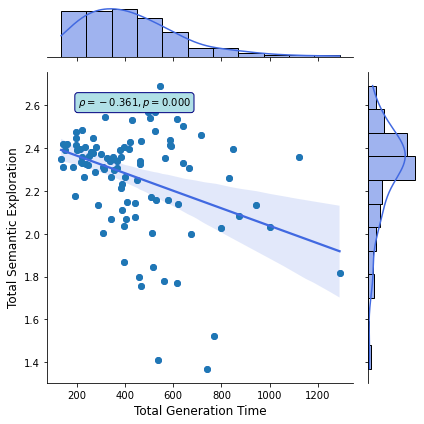

In [119]:
#just for stats

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Total Generation Time', ylabel='Total Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

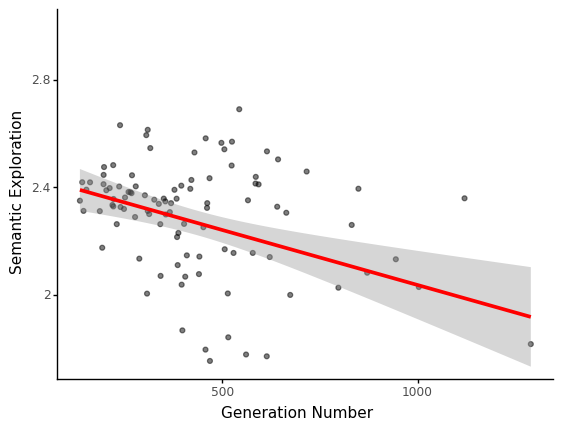

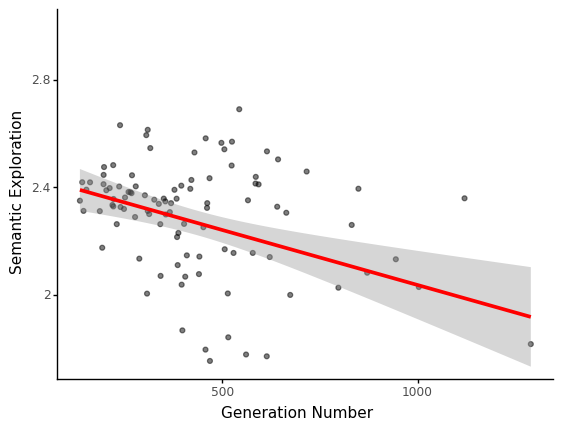

In [121]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Number") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(1.75,3)) + 
 plotnine.theme_classic()
).draw()


# **Successive Semantic Distance vs Generation Time**

In [123]:
distance = []
time = []

for id, group in tqdm(generations.groupby("id")):
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    times = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        times.append(list(group3["generation_time"])[0])
    for i in range(len(embeddings)-1):
      j = i+1
      distance.append(dist(embeddings[i], embeddings[j]))
      time.append(times[j])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:51<00:00,  2.00it/s]


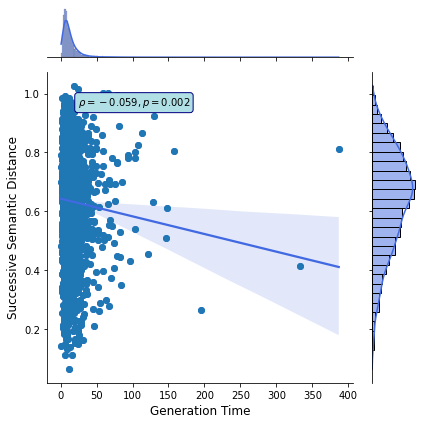

In [124]:
#just for stats
x = np.array(time)
y = distance
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Time', ylabel='Successive Semantic Distance', size=12)
plt.tight_layout()
plt.show()

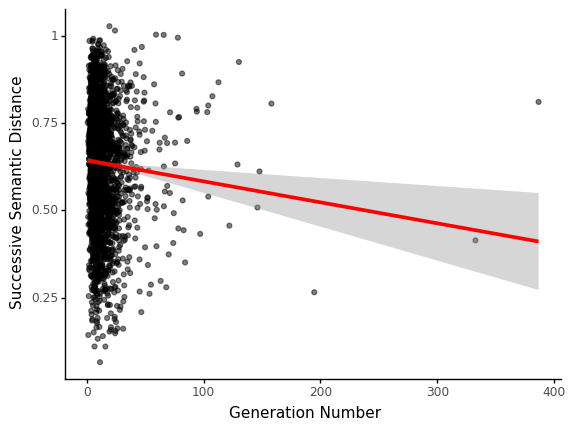

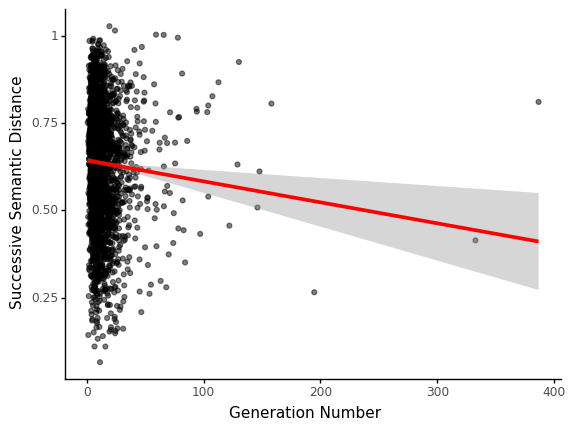

In [125]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Successive_Semantic_Distance"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Successive_Semantic_Distance'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Number") +
 plotnine.ylab("Successive Semantic Distance") + 
 plotnine.theme_classic()
).draw()


# **Distance from Center of Mass vs Time**

In [126]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

In [127]:
DCOM = []
time = []
for id,group in tqdm(generations.groupby("id")):
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    responses = []
    times = []
    for num, group3 in group2.groupby("generation_number"):
      responses.append(list(group3["response"])[0])
      times.append(list(group3["generation_time"])[0])
    for row in zip(responses, times):
      response = row[0]
      gtime = row[1]
      if not pd.isna(response):
        if len(embeddings) > 0:
          current = model.encode(response)
          COM = average_embedding(embeddings)
          DCOM.append(dist(current, COM))
          time.append(gtime)
        embeddings.append(model.encode(response))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [02:29<00:00,  1.46s/it]


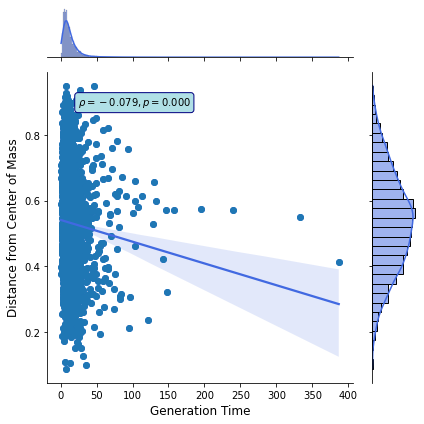

In [128]:
x = np.array(time)
y = DCOM
#just for stats
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Time', ylabel='Distance from Center of Mass', size=12)
plt.tight_layout()
plt.show()

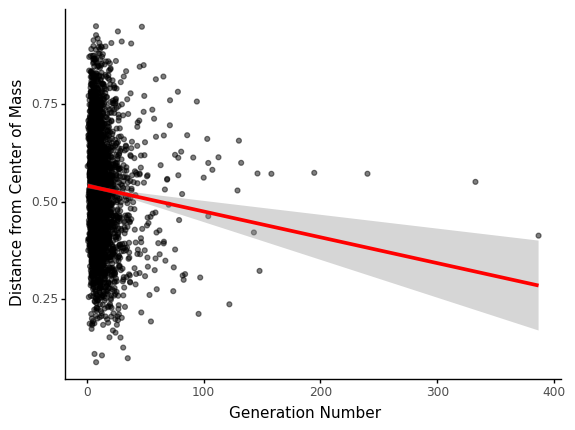

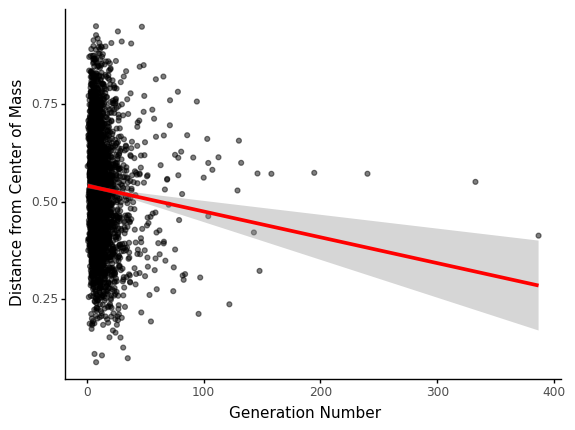

In [129]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "DCOM"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='DCOM'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Number") +
 plotnine.ylab("Distance from Center of Mass") + 
 plotnine.theme_classic()
).draw()


# **Total Time vs Generation Number**

In [135]:
#Total time vs possibility number
time = []
nums = []
times = {}
for id, group in tqdm(generations.groupby("id")):
  for pnum, group1 in group.groupby("generation_number"):
    if pnum not in times:
      times[pnum] = []
    for response, group2 in group1.groupby("response"):
      t = list(group2["generation_time"])[0]
      times[pnum].append(t)
      time.append(t)
      nums.append(pnum-1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 144.57it/s]


In [136]:
x_avg = [i for i in range(8)]
y_avg = []
for num in times:
  y_avg.append(sum(times[num])/len(times[num]))

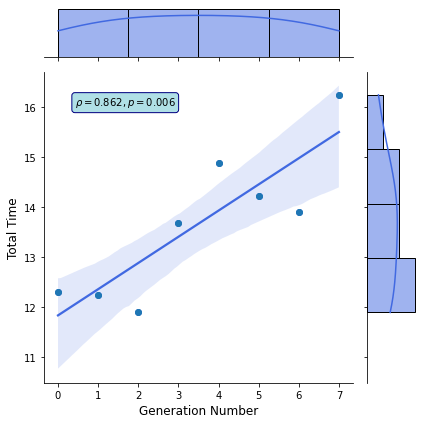

In [137]:

#just for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Total Time', size=12)
plt.tight_layout()
plt.show()

In [138]:
nums = np.array(nums)
time = np.array(time)
d = pd.DataFrame(data=[nums,time])
d = d.T
d.columns = ["Generation_Number", "Generation_Time"]
y_avg = np.array(y_avg)
d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Time"]

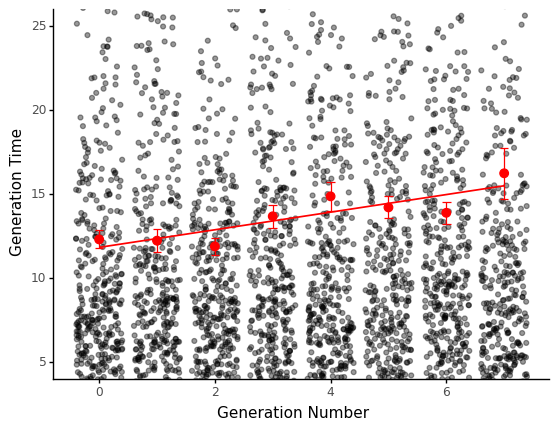

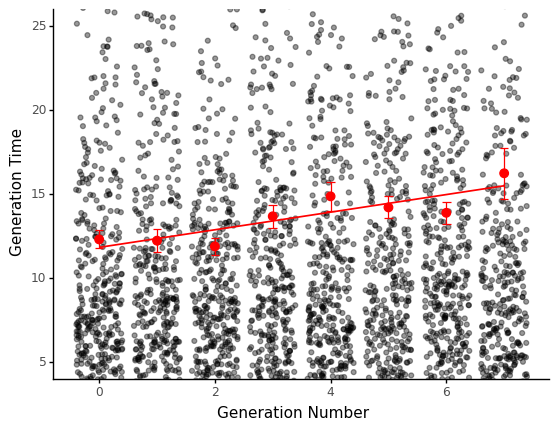

In [139]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Time"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Time'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.4) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Time-yerr",ymax="Generation_Time+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Time") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(5,25)) + 
 plotnine.theme_classic()
  ).draw()

# **Generation Concreteness vs Generation Time**

In [140]:
gc = []
time = []

for response, group in tqdm(generations.groupby("response")):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    gc.append(score)
    time.append(list(group["generation_time"])[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2720/2720 [00:00<00:00, 11326.37it/s]


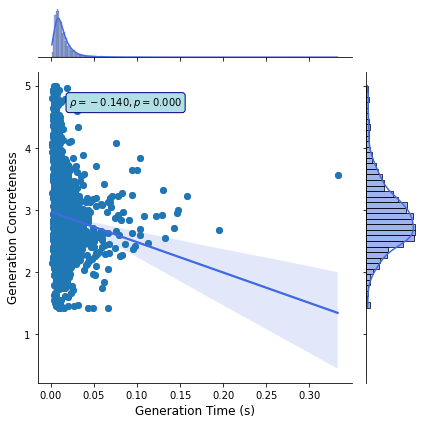

In [141]:
x = np.array(time)/1000
y= gc
#just for stats
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Time (s)', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

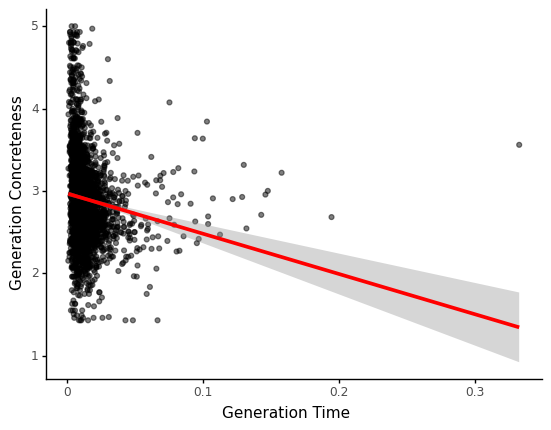

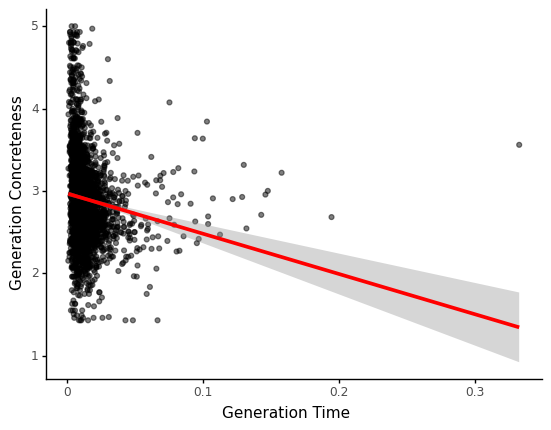

In [142]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Time", "Generation_Concreteness"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Time', y='Generation_Concreteness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Time") +
 plotnine.ylab("Generation Concreteness") + 
 plotnine.theme_classic()
).draw()
